In [1]:
#Description:
#   Pulling in data from all sources.  These sources include:
#
#   FBI Crime Data API - https://crime-data-explorer.fr.cloud.gov/api
#   FBI Crime Data API:  lookups-controller : Endpoints pertaining to CDE Related Lookup Value data (LIST OF STATES & AGENCIES)
#   FBI Crime Data API:  victim-data-controller : Endpoints pertaining to NIBRS Victim Demographic data (NATIONAL & STATE - HOMICIDE ONLY)
#   FBI Crime Data API:  offense-data-controller : Endpoints pertaining to NIBRS Offender Demographic data (NATIONAL & STATE - HOMICIDE ONLY)
#   CENSUS DATA CSV:  Used https://factfinder.census.gov to build a table of the data.  Exported that data from the website into a csv file (2017 YEAR ONLY)  
#   MURDER RATES:  By State:  https://deathpenaltyinfo.org/facts-and-research/murder-rates/murder-rates-by-state
# 
#
#Modification History:
#   DD-MMM-YYY  Author          Description
#   10-07-2019  Stacey Smith    INITIAL CREATION
#   12-07-2019  Andrea Morgan   API loop build
#   17-07-2019  Stacey Smith    Add Agency and Economic/Census data
#   18-07-2019  Stacey/Andrea/Karen  Consolidate data and plots


In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import csv
import scipy.stats as stats
import gmaps
from scipy.stats import ttest_ind
from math import sqrt
from numpy import mean
from scipy.stats import sem
from scipy.stats import t

from pprint import pprint

# Import DATA.GOV API key 
from api_keys import ses_dg_key, am_gkey, am_dg_key

In [2]:
#IMPORT CENSUS DATA
ses_census_path = "output_data/census_data.csv"
ses_census_df = pd.read_csv(ses_census_path, encoding="ISO-8859-1")

#IMPORT AGENCY DATA
agency_path = "output_data/final_agency_data.csv"
agency_df = pd.read_csv(agency_path, encoding="ISO-8859-1")
agency_df = agency_df.rename(columns={'State':'state_abbr'})
#agency_df_sorted = agency_df.sort_values(by=['Pct Active'], ascending=False)

#IMPORT MURDER RATE & DEATH PENALTY BY STATE (DEATH PENALTY.ORG) 
ses_mr_path = "output_data/Murder_Rates_and_Death_Penalty_by_State_2017.csv"
ses_mr_df = pd.read_csv(ses_mr_path, encoding="ISO-8859-1")
ses_mrcensus = pd.merge(ses_census_df, ses_mr_df, on='state_name')

#IMPORT VICTIM DATA BY STATE
state_v_sex_path = "output_data/state_v_sex_data.csv"
state_v_sex_df = pd.read_csv(state_v_sex_path, encoding="ISO-8859-1")
ses_state_v_sex_2017 = state_v_sex_df.loc[state_v_sex_df['Year']==2017, :]

NATIONAL FBI CRIME DATA  - EXPLORATION AND CLEANUP - VICTIM DATA ONLY (NO OFFENDERS)


In [3]:
#API Call to National-level victim-data-controller for HOMICIDE ONLY  
#FORMAT:  https://api.usa.gov/crime/fbi/sapi/api/data/nibrs/{offense}/victim/national/{variable}?api_key=

n_age_query_url = "https://api.usa.gov/crime/fbi/sapi/api/data/nibrs/homicide/victim/national/age?api_key=" + ses_dg_key
n_ethnicity_query_url = "https://api.usa.gov/crime/fbi/sapi/api/data/nibrs/homicide/victim/national/ethnicity?api_key=" + ses_dg_key
n_sex_query_url = "https://api.usa.gov/crime/fbi/sapi/api/data/nibrs/homicide/victim/national/sex?api_key=" + ses_dg_key
n_race_query_url = "https://api.usa.gov/crime/fbi/sapi/api/data/nibrs/homicide/victim/national/race?api_key=" + ses_dg_key
n_relationship_query_url = "https://api.usa.gov/crime/fbi/sapi/api/data/nibrs/homicide/victim/national/relationship?api_key=" + ses_dg_key

#Create JSON Files for each Homicide Variable
n_age_response = requests.get(n_age_query_url).json()
n_ethnicity_response = requests.get(n_ethnicity_query_url).json()
n_sex_response = requests.get(n_sex_query_url).json()
n_race_response = requests.get(n_race_query_url).json()
n_relationship_response = requests.get(n_relationship_query_url).json()


In [4]:
#NATIONAL VICTIMS OF HOMICIDE BY AGE RANGE

n_age_data = pd.DataFrame(n_age_response['results'])
n_age_data = n_age_data.sort_values(by='data_year', ascending=False)

n_age_data.to_csv("output_data/natl_age_data.csv")

n_age_data.head()

,data_year,range_0_9,range_10_19,range_20_29,range_30_39,range_40_49,range_50_59,range_60_69,range_70_79,range_80_89,range_90_99,unknown
12,2017,210,509,1547,1062,681,536,259,94,55,12,71
5,2016,204,415,1548,992,615,496,244,111,48,13,52
21,2015,210,388,1324,892,523,446,205,108,44,10,57
20,2014,208,302,1076,695,526,377,204,97,41,10,48
17,2013,170,328,1077,728,487,382,176,90,38,12,56


In [5]:
#NATIONAL VICTIMS OF HOMICIDE  BY ETHNICITY

n_eth_data = pd.DataFrame(n_ethnicity_response['results'])
n_eth_data.sort_values(by='data_year', ascending=False)

n_eth_data.to_csv("output_data/natl_eth_data.csv")

n_eth_data.head()

,data_year,hispanic,multiple,not_hispanic,unknown
0,2008,276,0,1908,545
1,2011,227,0,2236,604
2,2003,146,0,1469,214
3,2006,236,0,1937,624
4,2009,262,0,2136,477


In [6]:
#NATIONAL VICTIMS OF HOMICIDE  BY SEX

n_sex_data = pd.DataFrame(n_sex_response['results'])
n_sex_data.sort_values(by='data_year', ascending=False)

n_sex_data.to_csv("output_data/natl_sex_data.csv")

n_sex_data.head()

,data_year,female_count,male_count,unknown
0,2008,773,2449,28
1,2011,904,2619,13
2,2003,634,1491,7
3,2006,829,2548,25
4,2009,863,2579,8


In [7]:
#NATIONAL VICTIMS OF HOMICIDE  BY RACE

n_race_data = pd.DataFrame(n_race_response['results'])
n_race_data.sort_values(by='data_year', ascending=False)

n_race_data.to_csv("output_data/natl_race_data.csv")

n_race_data.head()

,american_indian,asian,black,data_year,native_hawaiian,unknown,white
0,17,25,1607,2008,0,93,1508
1,28,36,1815,2011,0,76,1581
2,6,26,954,2003,0,52,1094
3,14,35,1802,2006,0,66,1485
4,27,31,1710,2009,0,54,1628


In [8]:
#NATIONAL VICTIMS OF HOMICIDE BY RELATIONSHIP CATEGORY (RELATIONSHIP OF VICTIM TO OFFENDER)

n_rel_data = pd.DataFrame(n_relationship_response['results'])
n_rel_data.sort_values(by='data_year', ascending=False)

n_rel_data.to_csv("output_data/natl_rel_data.csv")

n_rel_data.head()

,acquaintance,babysittee,boyfriend_girlfriend,child,child_boyfriend_girlfriend,common_law_spouse,data_year,employee,employer,ex_spouse,...,other_family_member,otherwise_known,parent,relationship_unknown,sibling,spouse,stepchild,stepparent,stepsibling,stranger
0,836,11,173,148,27,16,2008,1,1,21,...,68,278,61,1465,39,153,17,10,5,670
1,196,2,29,17,5,8,1995,0,0,5,...,17,18,3,114,10,42,0,0,0,125
2,901,12,204,148,31,19,2011,1,3,22,...,73,297,70,1625,42,183,13,16,4,565
3,940,10,194,147,25,9,2013,0,1,14,...,56,321,80,1618,47,197,10,10,2,553
4,583,4,138,102,14,14,2003,3,6,11,...,44,159,48,850,23,129,11,9,2,411


STATE FBI CRIME DATA - EXPLORATION AND CLEANUP

In [9]:
#There are 3 pages of data for states. 
#This pulls the data for each page and combines it all into one usable dataframe: state_data

state_qry = "https://api.usa.gov/crime/fbi/sapi/api/states?api_key=" + ses_dg_key 
state_results_1 = requests.get(state_qry, params={'page':0}).json()
state_results_2 = requests.get(state_qry, params={'page':1}).json()
state_results_3 = requests.get(state_qry, params={'page':2}).json()

sr1_df = pd.DataFrame(state_results_1['results'])
sr2_df = pd.DataFrame(state_results_2['results'])
sr3_df = pd.DataFrame(state_results_3['results'])


state_data = pd.concat([sr1_df, sr2_df, sr3_df])
state_data.head()

,region_code,state_abbr,state_fips_code,state_id,state_name
0,4,AK,2.0,1,Alaska
1,3,AL,1.0,2,Alabama
2,3,AR,5.0,3,Arkansas
3,99,AS,60.0,4,American Samoa
4,4,AZ,4.0,5,Arizona


VICTIM DATA

In [10]:
#NUMBER OF VICTIMS OF HOMICIDE PER STATE BY AGE RANGE

#This is the same series created before
states = (state_data.iloc[:,1]).astype(str)

#Opened an empty list to initialize a dataframe
empty_list = []

v_ageDF = pd.DataFrame(empty_list)

#Creating columns on list based on the returned data for one state
v_ageDF["State"] = ""
v_ageDF["Year"] = ""
v_ageDF["Unknown"] = ""
v_ageDF["0-9"] = ""
v_ageDF["10-19"] = ""
v_ageDF["20-29"] = ""
v_ageDF["30-39"] = ""
v_ageDF["40-49"] = ""
v_ageDF["50-59"] = ""
v_ageDF["60-69"] = ""
v_ageDF["70-79"] = ""
v_ageDF["80-89"] = ""
v_ageDF["90-99"] = ""


#This is the loop to fill the dataframe.  This should work for any of us pulling the data from the FBI
#state APIs, with just tweaking the url, keyword and return information.

#The loop stores the return results for an individual state.  Then it loops through the return results to 
#populate each row in the empty dataframe created before.  Once it has looped through all of the return info,
#it goes back to the beginning and does the same for the next state in states.

#I found the "dataframe.append" bit on a website and it turned out to be the key to filling in the dataframe
#because it ignores index numbers and just appends to the next empty row available.  

for i in states:
    
    state = i 
    
    v_age_query_url = "https://api.usa.gov/crime/fbi/sapi/api/data/nibrs/homicide/victim/states/"+ state +"/age?api_key=" + ses_dg_key
    v_age_response_state = requests.get(v_age_query_url).json()
    
    for i in v_age_response_state['results']:
        
        v_ageDF = v_ageDF.append({'State': state, 
                          'Year': i['data_year'], 
                          'Unknown': i['unknown'],
                          '0-9' : i['range_0_9'],
                          '10-19' : i['range_10_19'],
                          '20-29' : i['range_20_29'],
                          '30-39' : i['range_30_39'],
                          '40-49' : i['range_40_49'],
                          '50-59' : i['range_50_59'],
                          '60-69' : i['range_60_69'],
                          '70-79' : i['range_70_79'],
                          '80-89' : i['range_80_89'],
                          '90-99' : i['range_90_99']},
                          ignore_index = True)
    

v_ageDF.to_csv("output_data/state_v_age_data.csv")

v_ageDF.head()  

,State,Year,Unknown,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-99
0,AL,1991,28,11,54,131,105,49,16,20,12,7,1
1,AL,1992,12,10,33,67,70,43,16,15,7,5,0
2,AL,2006,0,0,0,2,0,0,0,0,0,0,0
3,AL,2008,0,0,0,0,0,1,1,0,0,0,0
4,AL,2009,0,0,0,1,1,0,0,0,0,0,0


In [11]:
#NUMBER OF VICTIMS OF HOMICIDE PER STATE BY SEX

states = (state_data.iloc[:,1]).astype(str)

#Opened an empty list to initialize a dataframe
empty_list = []

sexDF = pd.DataFrame(empty_list)

#Creating columns on list based on the returned data for one state
sexDF["State"] = ""
sexDF["Year"] = ""
sexDF["Female Count"] = ""
sexDF["Male Count"] = ""
sexDF["Unknown"] = ""


#This is the loop to fill the dataframe.  This should work for any of us pulling the data from the FBI
#state APIs, with just tweaking the url, keyword and return information.

#The loop stores the return results for an individual state.  Then it loops through the return results to 
#populate each row in the empty dataframe created before.  Once it has looped through all of the return info,
#it goes back to the beginning and does the same for the next state in states.

#I found the "dataframe.append" bit on a website and it turned out to be the key to filling in the dataframe
#because it ignores index numbers and just appends to the next empty row available.  

for i in states:
    
    state = i 
    
    sex_query_url = "https://api.usa.gov/crime/fbi/sapi/api/data/nibrs/homicide/victim/states/"+ state +"/sex?api_key=" + ses_dg_key
    sex_response_state = requests.get(sex_query_url).json()
    
    for i in sex_response_state['results']:
        
        sexDF = sexDF.append({'State': state, 
                          'Year': i['data_year'], 
                          'Female Count': i['female_count'],
                          'Male Count' : i['male_count'],
                          'Unkown' : i['unknown']},
                          ignore_index = True)
    
    
sexDF.to_csv("output_data/state_v_sex_data.csv") 


sexDF.head()  

,State,Year,Female Count,Male Count,Unknown,Unkown
0,AL,1991,107,321,NaN,6.0
1,AL,1992,54,216,NaN,8.0
2,AL,2006,1,1,NaN,0.0
3,AL,2008,1,1,NaN,0.0
4,AL,2009,1,1,NaN,0.0


In [12]:
#NUMBER OF  VICTIMS OF HOMICIDE PER STATE BY RELATIONSHIP CATEGORY

#Opened an empty list to initialize a dataframe
empty_list = []

v_relDF = pd.DataFrame(empty_list)


#Creating columns on list based on the returned data for one state
v_relDF["State"] = ""
v_relDF["Year"] = ""
v_relDF["Relationship Unknown"] = ""
v_relDF["Acquaintance"] = ""
v_relDF["Babysittee"] = ""
v_relDF["BF_GF"] = ""
v_relDF["Child"] = ""
v_relDF["Child_BF_GF"] = ""
v_relDF["Common Law Spouse"] = ""
v_relDF["Employee"] = ""
v_relDF["Employer"] = ""
v_relDF["Ex Spouse"] = ""
v_relDF["Friend"] = ""
v_relDF["Grandchild"] = ""
v_relDF["Grandparent"] = ""
v_relDF["Same Sex Relationship"] = ""
v_relDF["In Law"] = ""
v_relDF["Neighbor"] = ""
v_relDF["Offender"] = ""
v_relDF["Other Family Member"] = ""
v_relDF["Otherwise Known"] = ""
v_relDF["Parent"] = ""
v_relDF["Sibling"] = ""
v_relDF["Spouse"] = ""
v_relDF["Stepchild"] = ""
v_relDF["Stepparent"] = ""
v_relDF["Stepsibling"] = ""
v_relDF["Stranger"] = ""


#This is the loop to fill the dataframe.  This should work for any of us pulling the data from the FBI
#state APIs, with just tweaking the url, keyword and return information.

#The loop stores the return results for an individual state.  Then it loops through the return results to 
#populate each row in the empty dataframe created before.  Once it has looped through all of the return info,
#it goes back to the beginning and does the same for the next state in states.

#I found the "dataframe.append" bit on a website and it turned out to be the key to filling in the dataframe
#because it ignores index numbers and just appends to the next empty row available.  

for i in states:
    
    state = i 
    
    v_rel_query_url = "https://api.usa.gov/crime/fbi/sapi/api/data/nibrs/homicide/victim/states/"+ state +"/relationship?api_key=" + ses_dg_key
    v_rel_response_state = requests.get(v_rel_query_url).json()
    
    for i in v_rel_response_state['results']:
        
        v_relDF = v_relDF.append({'State': state, 
                          'Year': i['data_year'], 
                          'Relationship Unknown': i['relationship_unknown'],
                          'Acquaintance' : i['acquaintance'],
                          'Babysittee' : i['babysittee'],
                          'BF_GF' : i['boyfriend_girlfriend'],
                          'Child' : i['child'],
                          'Child_BF_GF' : i['child_boyfriend_girlfriend'],
                          'Common Law Spouse' : i['common_law_spouse'],
                          'Employee' : i['employee'],
                          'Employer' : i['employer'],
                          'Ex Spouse' : i['ex_spouse'],
                          'Friend' : i['friend'],
                          'Grandchild' : i['grandchild'],
                             'Grandparent' : i['grandparent'], 
                             'Same Sex Relationship' : i['homosexual_relationship'], 
                             'In Law' : i['in_law'], 
                             'Neighbor' : i['neighbor'], 
                             'Offender' : i['offender'], 
                             'Other Family Member' : i['other_family_member'], 
                             'Otherwise Known' : i['otherwise_known'], 
                             'Parent' : i['parent'], 
                             'Relationship Unkown' : i['relationship_unknown'], 
                             'Sibling' : i['sibling'],
                             'Spouse' : i['spouse'],
                             'Stepchild' : i['stepchild'],
                             'Stepparent' : i['stepparent'],
                             'Stepsibling' : i['stepsibling'],
                             'Stranger' : i['stranger']},
                          ignore_index = True)
    
    
v_relDF.to_csv("output_data/state_v_rel_data.csv") 

v_relDF.head()

,State,Year,Relationship Unknown,Acquaintance,Babysittee,BF_GF,Child,Child_BF_GF,Common Law Spouse,Employee,...,Other Family Member,Otherwise Known,Parent,Sibling,Spouse,Stepchild,Stepparent,Stepsibling,Stranger,Relationship Unkown
0,AL,1991,86,136,0,48,9,0,4,3,...,16,1,7,6,38,0,2,0,179,86.0
1,AL,1992,126,76,0,17,7,0,5,0,...,11,1,3,4,20,1,1,0,45,126.0
2,AL,2006,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0.0
3,AL,2008,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.0
4,AL,2009,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0


OFFENDER DATA

In [13]:
#NUMBER HOMICIDE OFFENDERS PER STATE BY SEX

#Opened an empty list to initialize a dataframe
empty_list = []

o_ageDF = pd.DataFrame(empty_list)

#Creating columns on list based on the returned data for one state
o_ageDF["State"] = ""
o_ageDF["Year"] = ""
o_ageDF["Unknown"] = ""
o_ageDF["0-9"] = ""
o_ageDF["10-19"] = ""
o_ageDF["20-29"] = ""
o_ageDF["30-39"] = ""
o_ageDF["40-49"] = ""
o_ageDF["50-59"] = ""
o_ageDF["60-69"] = ""
o_ageDF["70-79"] = ""
o_ageDF["80-89"] = ""
o_ageDF["90-99"] = ""


#This is the loop to fill the dataframe.  This should work for any of us pulling the data from the FBI
#state APIs, with just tweaking the url, keyword and return information.

#The loop stores the return results for an individual state.  Then it loops through the return results to 
#populate each row in the empty dataframe created before.  Once it has looped through all of the return info,
#it goes back to the beginning and does the same for the next state in states.

#I found the "dataframe.append" bit on a website and it turned out to be the key to filling in the dataframe
#because it ignores index numbers and just appends to the next empty row available.  

for i in states:
    
    state = i 
    
    o_age_query_url = "https://api.usa.gov/crime/fbi/sapi/api/data/nibrs/homicide/offender/states/"+ state +"/age?api_key=" + ses_dg_key
    o_age_response_state = requests.get(o_age_query_url).json()
    
    for i in o_age_response_state['results']:
        
        o_ageDF = o_ageDF.append({'State': state, 
                          'Year': i['data_year'], 
                          'Unknown': i['unknown'],
                          '0-9' : i['range_0_9'],
                          '10-19' : i['range_10_19'],
                          '20-29' : i['range_20_29'],
                          '30-39' : i['range_30_39'],
                          '40-49' : i['range_40_49'],
                          '50-59' : i['range_50_59'],
                          '60-69' : i['range_60_69'],
                          '70-79' : i['range_70_79'],
                          '80-89' : i['range_80_89'],
                          '90-99' : i['range_90_99']},
                          ignore_index = True)
    
o_ageDF.to_csv("output_data/state_o_age_data.csv") 

o_ageDF.head() 

,State,Year,Unknown,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-99
0,AL,1991,353,0,51,82,72,30,11,5,1,2,0
1,AL,1992,102,0,46,94,52,36,13,6,4,1,0
2,AL,2006,0,0,3,2,0,0,0,0,0,0,0
3,AL,2008,0,0,2,0,1,0,0,0,0,0,0
4,AL,2009,0,0,0,1,0,2,0,0,0,0,0


In [14]:
#NUMBER OF HOMICIDE OFFENDERS PER STATE BY SEX

#Opened an empty list to initialize a dataframe
empty_list = []

o_sexDF = pd.DataFrame(empty_list)

#Creating columns on list based on the returned data for one state
o_sexDF["State"] = ""
o_sexDF["Year"] = ""
o_sexDF["Female Count"] = ""
o_sexDF["Male Count"] = ""
o_sexDF["Unknown"] = ""


#This is the loop to fill the dataframe.  This should work for any of us pulling the data from the FBI
#state APIs, with just tweaking the url, keyword and return information.

#The loop stores the return results for an individual state.  Then it loops through the return results to 
#populate each row in the empty dataframe created before.  Once it has looped through all of the return info,
#it goes back to the beginning and does the same for the next state in states.

#I found the "dataframe.append" bit on a website and it turned out to be the key to filling in the dataframe
#because it ignores index numbers and just appends to the next empty row available.  

for i in states:
    
    state = i 
    
    o_sex_query_url = "https://api.usa.gov/crime/fbi/sapi/api/data/nibrs/homicide/offender/states/"+ state +"/sex?api_key=" + ses_dg_key
    o_sex_response_state = requests.get(o_sex_query_url).json()
    
    for i in o_sex_response_state['results']:
        
        o_sexDF = o_sexDF.append({'State': state, 
                          'Year': i['data_year'], 
                          'Female Count': i['female_count'],
                          'Male Count' : i['male_count'],
                          'Unkown' : i['unknown']},
                          ignore_index = True)
    
    
o_sexDF.to_csv("output_data/state_o_sex_data.csv") 

o_sexDF.head()

,State,Year,Female Count,Male Count,Unknown,Unkown
0,AL,1991,44,237,NaN,326.0
1,AL,1992,48,240,NaN,66.0
2,AL,2006,0,5,NaN,0.0
3,AL,2008,0,3,NaN,0.0
4,AL,2009,1,2,NaN,0.0


AGENCY FBI CRIME DATA - EXPLORATION AND CLEANUP

In [15]:
#AGENCY DATA BY STATE - RAW DATA
#Opened an empty list to initialize a dataframe
empty_list = []

agencies = pd.DataFrame(empty_list)

#Creating columns on list based on the returned data for one state
agencies["State"] = ""
agencies["Origin"] = ""
agencies["Agency Name"] = ""
agencies["Agency Type Name"] = ""
agencies["State Abbr"] = ""
agencies["Division Name"] = ""
agencies["Region Name"] = ""
agencies["Region Desc"] = ""
agencies["County Name"] = ""
agencies["NIBRS"] = ""
agencies["Latitude"] = ""          
agencies["Longitude"] = ""
agencies["NIBRS Start Date"] = ""

#This is the loop to fill the dataframe.  This should work for any of us pulling the data from the FBI
#state APIs, with just tweaking the url, keyword and return information.

#The loop stores the return results for an individual state.  Then it loops through the return results to 
#populate each row in the empty dataframe created before.  Once it has looped through all of the return info,
#it goes back to the beginning and does the same for the next state in states.

#I found the "dataframe.append" bit on a website and it turned out to be the key to filling in the dataframe
#because it ignores index numbers and just appends to the next empty row available.  

for i in states:
    
    state = i 
    
    agency_query_url = "https://api.usa.gov/crime/fbi/sapi/api/agencies/byStateAbbr/"+ state +"?api_key=" + ses_dg_key
    agency_response_state = requests.get(agency_query_url).json()
    
    for i in agency_response_state['results']:
        
        agencies = agencies.append({'State': state, 
                          'Origin': i['ori'], 
                          'Agency Name': i['agency_name'],
                          'Agency Type Name' : i['agency_type_name'],
                          'State Abbr' : i['state_abbr'],
                          'Division Name' : i['division_name'],
                          'Region Name' : i['region_name'],
                          'Region Desc' : i['region_desc'],
                          'County Name' : i['county_name'],
                          'NIBRS' : i['nibrs'],
                          'Latitude' : i['latitude'],
                          'Longitude' : i['longitude'],
                          'NIBRS Start Date' : i['nibrs_start_date']},
                          ignore_index = True)
    

agencies.to_csv("output_data/raw_agencies.csv") 

agencies.head()

KeyError: 'results'

In [ ]:
#AGENCY DATA CLEANUP
#NEED TO FIND THE NUMBERS OF AGENCIES REPORTING DATA TO THE FBI 

#Gives me a total count of all agencies, both True and False for NIBRS
NIBRS_data = agencies.groupby(['State']).count()

#Gives me a series that contains just the counts of True and False NIBRS by State
NIBRS_data_s = agencies.groupby(['State', 'NIBRS']).size()

#Put the series into a dataframe
NIBRS_df = pd.DataFrame(NIBRS_data_s)
NIBRS_df.reset_index(level=['State', 'NIBRS'], inplace=True)

#Merge the dataframes
all_agency = pd.merge(NIBRS_data, NIBRS_df, on=['State'])

#Cleanup columns I don't want
del all_agency['Origin']
del all_agency['Agency Name']
del all_agency['Agency Type Name']
del all_agency['State Abbr']
del all_agency['Division Name']
del all_agency['Region Name']
del all_agency['Region Desc']
del all_agency['County Name']
del all_agency['Latitude']
del all_agency['Longitude']
del all_agency['NIBRS Start Date']

#Create final dataframe
t_all_agency = all_agency.loc[all_agency['NIBRS_y']==True, :]

all_agencies = t_all_agency.rename(columns={
    "NIBRS_x": "Total Agencies",
    0: "Active Agencies"
    
})

#Get rid of one more column
del all_agencies['NIBRS_y']

#Add a new column that calculates the percentage of agencies reporting data to the FBI
all_agencies['Pct Active'] = (all_agencies['Active Agencies']/all_agencies['Total Agencies'])*100

all_agencies.to_csv("output_data/final_agency_data.csv")

all_agencies.head()

CENSUS DATA - EXPLORATION AND CLEANUP

In [ ]:
#Open the Census Economic data CSV file
path_econ = "Resources/ACS_17_5YR_DP03_with_ann.csv"
econ_df = pd.read_csv(path_econ, encoding="ISO-8859-1")


#CLEAN AND ORGANIZE THE DATA
# For the purposes of this analysis, I only want to use a small portion of the data I downloaded from the census website. 
 
# Delete unwanted data 
del econ_df['Id2']
del econ_df['Estimate; EMPLOYMENT STATUS - Civilian labor force']
del econ_df['Percent; EMPLOYMENT STATUS - Civilian labor force']
del econ_df['Percent; EMPLOYMENT STATUS - Civilian labor force - Unemployment Rate']
del econ_df['Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people - Under 18 years - Related children of the householder under 18 years'] 
del econ_df['Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people - Under 18 years - Related children of the householder under 18 years']
del econ_df['Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people - Under 18 years - Related children of the householder under 18 years - Related children of the householder 5 to 17 years']
del econ_df['Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people - Under 18 years - Related children of the householder under 18 years - Related children of the householder 5 to 17 years']
del econ_df['Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people - 18 years and over - 18 to 64 years']
del econ_df['Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people - 18 years and over - 18 to 64 years']
del econ_df['Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people - 18 years and over - 65 years and over']
del econ_df['Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people - 18 years and over - 65 years and over']
del econ_df['Estimate; EMPLOYMENT STATUS - Females 16 years and over - In labor force'],
del econ_df['Percent; EMPLOYMENT STATUS - Females 16 years and over - In labor force'],
del econ_df['Estimate; EMPLOYMENT STATUS - Females 16 years and over - In labor force - Civilian labor force'],
del econ_df['Percent; EMPLOYMENT STATUS - Females 16 years and over - In labor force - Civilian labor force'],
del econ_df['Estimate; EMPLOYMENT STATUS - Females 16 years and over - In labor force - Civilian labor force - Employed'],
del econ_df['Percent; EMPLOYMENT STATUS - Females 16 years and over - In labor force - Civilian labor force - Employed'],
del econ_df['Estimate; COMMUTING TO WORK - Workers 16 years and over'],
del econ_df['Percent; COMMUTING TO WORK - Workers 16 years and over'],
del econ_df['Estimate; COMMUTING TO WORK - Workers 16 years and over - Car, truck, or van -- drove alone'],
del econ_df['Percent; COMMUTING TO WORK - Workers 16 years and over - Car, truck, or van -- drove alone'],
del econ_df['Estimate; COMMUTING TO WORK - Workers 16 years and over - Car, truck, or van -- carpooled'],
del econ_df['Percent; COMMUTING TO WORK - Workers 16 years and over - Car, truck, or van -- carpooled'],
del econ_df['Estimate; COMMUTING TO WORK - Workers 16 years and over - Public transportation (excluding taxicab)'],
del econ_df['Percent; COMMUTING TO WORK - Workers 16 years and over - Public transportation (excluding taxicab)'],
del econ_df['Estimate; COMMUTING TO WORK - Workers 16 years and over - Walked'],
del econ_df['Percent; COMMUTING TO WORK - Workers 16 years and over - Walked'],
del econ_df['Estimate; COMMUTING TO WORK - Workers 16 years and over - Other means'],
del econ_df['Percent; COMMUTING TO WORK - Workers 16 years and over - Other means'],
del econ_df['Estimate; COMMUTING TO WORK - Workers 16 years and over - Worked at home'],
del econ_df['Percent; COMMUTING TO WORK - Workers 16 years and over - Worked at home'],
del econ_df['Estimate; COMMUTING TO WORK - Mean travel time to work (minutes)'],
del econ_df['Estimate; OCCUPATION - Civilian employed population 16 years and over'],
del econ_df['Percent; OCCUPATION - Civilian employed population 16 years and over'],
del econ_df['Estimate; OCCUPATION - Civilian employed population 16 years and over - Management, business, science, and arts occupations'],
del econ_df['Percent; OCCUPATION - Civilian employed population 16 years and over - Management, business, science, and arts occupations'],
del econ_df['Estimate; OCCUPATION - Civilian employed population 16 years and over - Service occupations'],
del econ_df['Percent; OCCUPATION - Civilian employed population 16 years and over - Service occupations'],
del econ_df['Estimate; OCCUPATION - Civilian employed population 16 years and over - Sales and office occupations'],
del econ_df['Percent; OCCUPATION - Civilian employed population 16 years and over - Sales and office occupations'],
del econ_df['Estimate; OCCUPATION - Civilian employed population 16 years and over - Natural resources, construction, and maintenance occupations'],
del econ_df['Percent; OCCUPATION - Civilian employed population 16 years and over - Natural resources, construction, and maintenance occupations'],
del econ_df['Estimate; OCCUPATION - Civilian employed population 16 years and over - Production, transportation, and material moving occupations'],
del econ_df['Percent; OCCUPATION - Civilian employed population 16 years and over - Production, transportation, and material moving occupations'],
del econ_df['Estimate; CLASS OF WORKER - Civilian employed population 16 years and over'],
del econ_df['Percent; CLASS OF WORKER - Civilian employed population 16 years and over'],
del econ_df['Estimate; CLASS OF WORKER - Civilian employed population 16 years and over - Private wage and salary workers'],
del econ_df['Percent; CLASS OF WORKER - Civilian employed population 16 years and over - Private wage and salary workers'],
del econ_df['Estimate; CLASS OF WORKER - Civilian employed population 16 years and over - Government workers'],
del econ_df['Percent; CLASS OF WORKER - Civilian employed population 16 years and over - Government workers'],
del econ_df['Estimate; CLASS OF WORKER - Civilian employed population 16 years and over - Self-employed in own not incorporated business workers'],
del econ_df['Percent; CLASS OF WORKER - Civilian employed population 16 years and over - Self-employed in own not incorporated business workers'],
del econ_df['Estimate; CLASS OF WORKER - Civilian employed population 16 years and over - Unpaid family workers'],
del econ_df['Percent; CLASS OF WORKER - Civilian employed population 16 years and over - Unpaid family workers'],
del econ_df['Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households'],
del econ_df['Percent; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households'],
del econ_df['Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - Less than $10,000'],
del econ_df['Percent; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - Less than $10,000'],
del econ_df['Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $10,000 to $14,999'],
del econ_df['Percent; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $10,000 to $14,999'],
del econ_df['Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $15,000 to $24,999'],
del econ_df['Percent; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $15,000 to $24,999'],
del econ_df['Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $25,000 to $34,999'],
del econ_df['Percent; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $25,000 to $34,999'],
del econ_df['Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $35,000 to $49,999'],
del econ_df['Percent; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $35,000 to $49,999'],
del econ_df['Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $50,000 to $74,999'],
del econ_df['Percent; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $50,000 to $74,999'],
del econ_df['Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $75,000 to $99,999'],
del econ_df['Percent; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $75,000 to $99,999'],
del econ_df['Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $100,000 to $149,999'],
del econ_df['Percent; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $100,000 to $149,999'],
del econ_df['Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $150,000 to $199,999'],
del econ_df['Percent; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $150,000 to $199,999'],
del econ_df['Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $200,000 or more'],
del econ_df['Percent; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $200,000 or more'],
del econ_df['Estimate; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population'],
del econ_df['Percent; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population'],
del econ_df['Estimate; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population - With health insurance coverage'],
del econ_df['Percent; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population - With health insurance coverage'],
del econ_df['Estimate; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population - With health insurance coverage - With private health insurance'],
del econ_df['Percent; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population - With health insurance coverage - With private health insurance'],
del econ_df['Estimate; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population - With health insurance coverage - With public coverage'],
del econ_df['Percent; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population - With health insurance coverage - With public coverage'],
del econ_df['Estimate; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population - No health insurance coverage'],
del econ_df['Percent; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population - No health insurance coverage'],
del econ_df['Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people'],
del econ_df['Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people'],
del econ_df['Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people - Under 18 years'],
del econ_df['Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people - Under 18 years'],
del econ_df['Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people - 18 years and over'],
del econ_df['Percent; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Median earnings for workers (dollars)'],
del econ_df['Percent; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Median earnings for male full-time, year-round workers (dollars)'],
del econ_df['Percent; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - Median household income (dollars)'],
del econ_df['Percent; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Median earnings for female full-time, year-round workers (dollars)'],
del econ_df['Percent; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - Mean household income (dollars)'],
del econ_df['Percent; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Per capita income (dollars)']


# Original column names are ridiculous.  Shortening them to something more manageable.
# Also need to make sure the 'Geography' column is renamed to 'state_name' so I can merge with my state data later on.

# Rename columns and create a new dataframe from the result
o_econ_df = econ_df.rename(index=str, columns={
    
    'Geography': "state_name", 
    'Estimate; EMPLOYMENT STATUS - Population 16 years and over': "Emp_pop_all",
    'Percent; EMPLOYMENT STATUS - Population 16 years and over': "Pct_Emp_pop_all",
    'Estimate; EMPLOYMENT STATUS - Population 16 years and over - Not in labor force': "UnEmp_pop_all",
    'Percent; EMPLOYMENT STATUS - Population 16 years and over - Not in labor force': "Pct_UnEmp_pop_all",
    'Estimate; EMPLOYMENT STATUS - Females 16 years and over': "Emp_pop_Female",
    'Percent; EMPLOYMENT STATUS - Females 16 years and over': "Pct_Emp_pop_Female",
    'Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people - 18 years and over': "Pct_Pov_pop_all18",
    'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - Median household income (dollars)': "Total_median_income",
    'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - Mean household income (dollars)': "Total_mean_income",
    'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Per capita income (dollars)': "Per_capita_income",
    'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Median earnings for workers (dollars)': "Median_earnings",
    'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Median earnings for male full-time, year-round workers (dollars)': "Median_male",
    'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Median earnings for female full-time, year-round workers (dollars)': "Median_female"

   
})

# Merge the state data and my econ data on the state_name.  This allows me to bring the state_abbr column into the df, which I will need later on. 
o_econ_df_s = pd.merge(o_econ_df, state_data, on="state_name")

o_econ_df_s.to_csv("output_data/census_data.csv")

o_econ_df_s.head()

In [ ]:
#MURDER RATES AND DEATH PENALTY BY STATE
#I only want data for 2017

#IMPORT MURDER RATE & DEATH PENALTY BY STATE (DEATH PENALTY.ORG) 
ses_mr_path = "Resources/Murder_Rates_By_State_data.csv"
ses_mr_df = pd.read_csv(ses_mr_path, encoding="ISO-8859-1")
ses_mr_df = ses_mr_df.rename(columns={"State": "state_name"})
ses_mr_2017 = ses_mr_df.loc[ses_mr_df['Year']=='1/1/2017', :]

ses_mr_2017.to_csv("output_data/Murder_Rates_and_Death_Penalty_by_State_2017.csv")

ses_mr_2017.head()

# State of the Nation:  Looking at Overall Homicide Counts and Homicide Rates

In [16]:
#Data grab from FBI Victim API at https://crime-data-explorer.fr.cloud.gov/api

AM_age_query = "https://api.usa.gov/crime/fbi/sapi/api/data/nibrs/homicide/victim/national/age?api_key="+ am_dg_key
AM_age_response = requests.get(AM_age_query).json()


In [17]:
#Creating DF by ages/cleaning and formatting data/totalling counts
AM_age_data = pd.DataFrame(AM_age_response['results'])
AM_age_data = AM_age_data.sort_values(by='data_year', ascending=False)
AM_age_data = AM_age_data.reset_index(drop=True)
AM_age_data["Total"] = (AM_age_data.sum(axis=1)) - AM_age_data['data_year']

#Creating data frame to house total count information
counts_by_year = AM_age_data[['data_year', 'Total']]
counts_by_year = counts_by_year.loc[counts_by_year['data_year']>= 2007, :]

In [21]:
#Pulling in data about US Murder Rates to compare with counts
#Rates pre 2015 from: https://www.ucrdatatool.gov/Search/Crime/State/StateCrime.cfm
#Rates post 2014 from: https://www.cdc.gov/nchs/pressroom/sosmap/homicide_mortality/homicide.htm

csv = "Resources/US_Murder_Rates.csv"
national_rates = pd.read_csv(csv)
national_rates = national_rates.loc[national_rates["Year"]!='\t\t']
national_rates["Year"] = national_rates["Year"].astype(int)
national_rates = national_rates.loc[national_rates["Year"]>=2007,:]
national_rates = national_rates.sort_values(by='Year', ascending = False)
national_rates

counts_by_year["Murder Rate"] = national_rates["United States-Total"].values


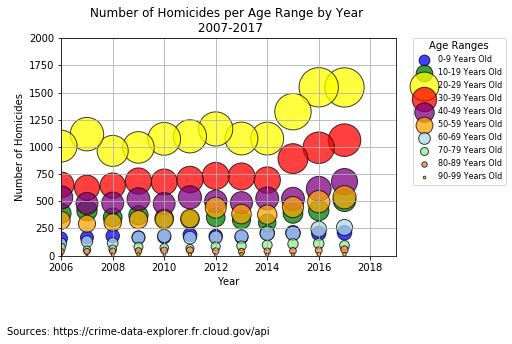

In [24]:
year = AM_age_data['data_year']
range0 = AM_age_data['range_0_9']
range1 = AM_age_data['range_10_19']
range2 = AM_age_data['range_20_29']
range3 = AM_age_data['range_30_39']
range4 = AM_age_data['range_40_49']
range5 = AM_age_data['range_50_59']
range6 = AM_age_data['range_60_69']
range7 = AM_age_data['range_70_79']
range8 = AM_age_data['range_80_89']
range9 = AM_age_data['range_90_99']

plt.scatter(year, range0, marker="o", facecolors="blue", edgecolors="black", alpha=0.75, label='0-9 Years Old' ,s=range0)
plt.scatter(year, range1, marker="o", facecolors="green", edgecolors="black", alpha=0.75, label='10-19 Years Old', s=range1) 
plt.scatter(year, range2, marker="o", facecolors="yellow", edgecolors="black", alpha=0.75, label='20-29 Years Old', s=range2) 
plt.scatter(year, range3, marker="o", facecolors="red", edgecolors="black", alpha=0.75, label='30-39 Years Old', s=range3) 
plt.scatter(year, range4, marker="o", facecolors="purple", edgecolors="black", alpha=0.75, label='40-49 Years Old', s=range4) 
plt.scatter(year, range5, marker="o", facecolors="orange", edgecolors="black", alpha=0.75, label='50-59 Years Old', s=range5) 
plt.scatter(year, range6, marker="o", facecolors="lightblue", edgecolors="black", alpha=0.75, label='60-69 Years Old', s=range6) 
plt.scatter(year, range7, marker="o", facecolors="lightgreen", edgecolors="black", alpha=0.75, label='70-79 Years Old', s=range7) 
plt.scatter(year, range8, marker="o", facecolors="coral", edgecolors="black", alpha=0.75, label='80-89 Years Old', s=range8) 
plt.scatter(year, range9, marker="o", facecolors="gold", edgecolors="black", alpha=0.75, label='90-99 Years Old', s=range9) 


#Incorporate the other graph properties
plt.grid()

plt.xlim(left=2006, right=2019)
plt.ylim(bottom=0, top=2000)

plt.xlabel("Year")
plt.ylabel("Number of Homicides")
plt.title("Number of Homicides per Age Range by Year \n 2007-2017")

#Create a legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize = 8, title= "Age Ranges") 
plt.figtext(0, -.15, 'Sources: https://crime-data-explorer.fr.cloud.gov/api', horizontalalignment='left')

#Save Figure
plt.savefig("Images/Counts_by_Age.png", bbox_inches='tight',pad_inches=1)


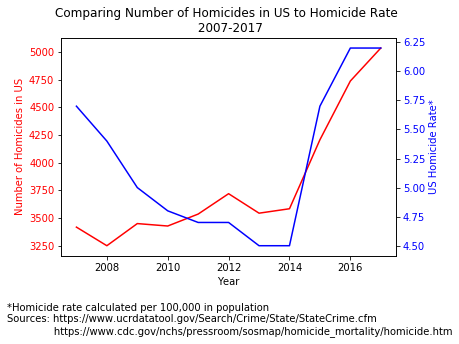

In [25]:
year = counts_by_year['data_year']
total_cts = counts_by_year['Total']
rates = counts_by_year['Murder Rate']

fig, ax1 = plt.subplots() 

ax1.plot(year, total_cts, color = 'red', label = 'Number of Homicides')
ax1.set_ylabel('Number of Homicides in US', color = 'red')
ax1.set_xlabel('Year')
ax1.tick_params(axis='y', labelcolor='red')

ax2=ax1.twinx()
ax2.plot(year, rates, color = 'blue', label = 'Rate of Homicides')
ax2.set_ylabel('US Homicide Rate*', color = 'blue')
ax2.tick_params(axis='y', labelcolor='blue')


plt.title("Comparing Number of Homicides in US to Homicide Rate \n 2007-2017")
plt.figtext(0, -.15, '*Homicide rate calculated per 100,000 in population \n' \
            'Sources: https://www.ucrdatatool.gov/Search/Crime/State/StateCrime.cfm \n'\
            '               https://www.cdc.gov/nchs/pressroom/sosmap/homicide_mortality/homicide.htm', \
            horizontalalignment='left')



plt.savefig("Images/Counts_vs_Rate.png", bbox_inches='tight',pad_inches=1)



## Looking at Public Perception v. Homicide Rates

In [26]:
#us homicide rates from https://www.ucrdatatool.gov/Search/Crime/State/StateCrime.cfm and
#https://www.cdc.gov/nchs/pressroom/sosmap/homicide_mortality/homicide.htm

#Confidence data from https://www.people-press.org/2019/04/11/public-trust-in-government-1958-2019/

#Approval Ratings from https://news.gallup.com/interactives/185273/presidential-job-approval-center.aspx

csv1="Resources/US_Murder_Rates.csv"
csv2="Resources/GovtConfidence.csv"
csv3="Resources/PublicApproval.csv"

us_rates=pd.read_csv(csv1)
confidence=pd.read_csv(csv2)
approval=pd.read_csv(csv3)

#Cleaning unusable data
us_rates=us_rates.loc[us_rates["Year"]!='\t\t',:]
us_rates = us_rates.dropna()

#Using only data from 2007 or later
us_rates["Year"]=us_rates["Year"].astype(int)
us_rates=us_rates.loc[us_rates["Year"]>=2007,:]

confidence['Year']=confidence['Year'].astype(int)
confidence=confidence.loc[confidence['Year']<2018,:]
confidence = confidence.loc[confidence['Year']>=2007,:]

approval['Year']=approval['Year'].astype(int)
approval=approval.loc[approval['Year']<2018,:]

confidence_grouped=confidence.groupby('Year').mean()


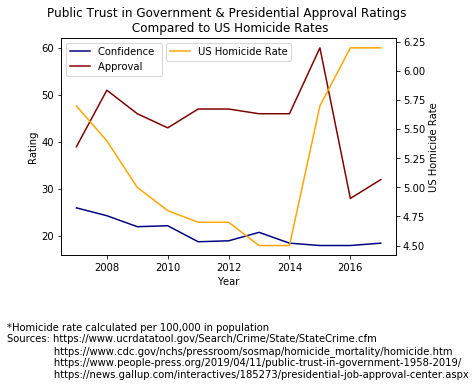

In [27]:
#Plotting Ratings vs Homicide Rates

x=us_rates["Year"]
conf=confidence_grouped["Moving Average"]
app= approval["Rating"]
rates=us_rates["United States-Total"]

fig, ax1 = plt.subplots()


ax1.plot(x, conf, color='navy', label="Confidence ")
ax1.plot(x, app, color='maroon', label="Approval ")
ax1.set_ylabel('Rating')

ax2=ax1.twinx()
ax2.plot(x, rates, color="orange", label="US Homicide Rate")
ax2.set_ylabel('US Homicide Rate')
ax1.set_xlabel('Year')

ax1.legend()
ax2.legend(loc="upper center")

plt.title("Public Trust in Government & Presidential Approval Ratings \n Compared to US Homicide Rates")
plt.figtext(0, -.3, '*Homicide rate calculated per 100,000 in population \n' \
            'Sources: https://www.ucrdatatool.gov/Search/Crime/State/StateCrime.cfm \n'\
            '               https://www.cdc.gov/nchs/pressroom/sosmap/homicide_mortality/homicide.htm \n' \
            '               https://www.people-press.org/2019/04/11/public-trust-in-government-1958-2019/ \n'\
            '               https://news.gallup.com/interactives/185273/presidential-job-approval-center.aspx', \
            horizontalalignment='left')

plt.savefig("Images/Public_Opinion_V_Rates.png", bbox_inches='tight', pad_inches=1)



## Homicide Rates by State/Year 

In [29]:
#Reading csv file containing state homicide rates by year
#Data from https://www.ucrdatatool.gov/Search/Crime/State/StateCrime.cfm 
#and https://www.cdc.gov/nchs/pressroom/sosmap/homicide_mortality/homicide.htm
csv="Resources/Homicide_Rates_State.csv"
state_rates=pd.read_csv(csv)
#once merged change the filepath

#Cleaning unusable data
state_rates=state_rates.loc[state_rates["Year"]!='\t\t',:]
state_rates = state_rates.dropna()

#Using only data from 2007 or later
state_rates["Year"]=state_rates["Year"].astype(int)

current_rates=state_rates.loc[state_rates["Year"]>=2007,:]

#Formatting data
transposed_rates=current_rates.T

transposed_rates=transposed_rates.rename(columns={47:"HR'07",
                                           48:"HR'08",
                                           49:"HR'09",
                                           50:"HR'10",
                                           51:"HR'11",
                                           52:"HR'12",
                                           53:"HR'13",
                                           54:"HR'14",
                                           55:"HR'15",
                                           56:"HR'16",
                                           57:"HR'17",})

final_HRates=transposed_rates.drop(["Year", "United States-Total"])

final_HRates = final_HRates.reset_index()
final_HRates.head()

/anaconda3/envs/PythonData37/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,index,HR'07,HR'08,HR'09,HR'10,HR'11,HR'12,HR'13,HR'14,HR'15,HR'16,HR'17
0,Alabama,8.9,7.5,6.8,5.7,6.2,7.1,7.2,5.7,10.2,11.8,12.9
1,Alaska,6.3,3.9,3.1,4.3,4.1,4.1,4.6,5.6,8.0,7.3,10.6
2,Arizona,8.6,7.1,5.8,6.4,6.1,5.5,5.4,4.7,5.5,6.3,6.6
3,Arkansas,7.0,5.8,6.2,4.6,5.4,5.9,5.3,5.6,7.4,8.7,9.8
4,California,6.2,5.8,5.3,4.8,4.8,5.0,4.5,4.4,5.0,5.3,5.1


## State Homicide Rates by Designation
### *in Presidential Election Years 2008, 2012, 2016

In [31]:
#once merged change the filepath

#Reading csv file containing historical electoral college data, from 
#https://www.archives.gov/federal-register/electoral-college/votes/2000_2005.html#2004
csv="Resources/ElectoralCollegeData.csv"
votesDF=pd.read_csv(csv)

#Only using data from 2007 or after; Designating states as "Red" or "Blue" based on majority of
#electoral vote
votesDF = votesDF.loc[votesDF["Year"] >2007,:]
votesDF['Designation'] = np.where(votesDF['Rep Total']> votesDF['Dem Total'], 'Red', 'Blue')

#Formatting DF to include both designations and homicide rates for election years
designationDF=votesDF.loc[votesDF["Year"]==2008, ["State", "Designation"]]

designationDF=designationDF.rename(columns = {"Designation":'2008'})

designationDF['2012']=votesDF.loc[votesDF["Year"]==2012,["Designation"]].values
designationDF['2016']=votesDF.loc[votesDF["Year"]==2016,["Designation"]].values

politicsDF=designationDF.loc[designationDF["State"]!="District of Columbia",:]
politicsDF=politicsDF.reset_index(drop=True)

politicsDF["HRate 08"]= final_HRates["HR'08"].values
politicsDF["HRate 12"]= final_HRates["HR'12"].values
politicsDF["HRate 16"]= final_HRates["HR'16"].values

politicsDF.loc[politicsDF["State"]=="Nebraska\xa0", "State"]="Nebraska"

#once merged change the filepath
#reading in data to assign general state coordinates
#data from https://developers.google.com/public-data/docs/canonical/states_csv
csv = "Resources/state_lat_long.csv"
coords = pd.read_csv(csv)
coords = coords.rename(columns = {"name":"State", "state":"Abbv"})

#Merging politicsDF and coordsDF for one complete DF
poli_map = pd.merge(politicsDF, coords, on="State", how = 'inner')
poli_map.head()

,State,2008,2012,2016,HRate 08,HRate 12,HRate 16,Abbv,latitude,longitude
0,Alabama,Red,Red,Red,7.5,7.1,11.8,AL,32.318231,-86.902298
1,Alaska,Red,Red,Red,3.9,4.1,7.3,AK,63.588753,-154.493062
2,Arizona,Red,Red,Red,7.1,5.5,6.3,AZ,34.048928,-111.093731
3,Arkansas,Red,Red,Red,5.8,5.9,8.7,AR,35.201050,-91.831833
4,California,Blue,Blue,Blue,5.8,5.0,5.3,CA,36.778261,-119.417932


### Creating individual dataframes for each designation in each election year

In [32]:
poli_08_blue = poli_map.loc[poli_map["2008"]=="Blue", :]
poli_08_blue = poli_08_blue[["Abbv", "2008", "HRate 08", "latitude", "longitude"]]

poli_08_red = poli_map.loc[poli_map["2008"]=="Red", :]
poli_08_red = poli_08_red[["Abbv", "2008", "HRate 08", "latitude", "longitude"]]

poli_12_blue = poli_map.loc[poli_map["2012"]=="Blue", :]
poli_12_blue = poli_12_blue[["Abbv", "2012", "HRate 12", "latitude", "longitude"]]

poli_12_red = poli_map.loc[poli_map["2012"]=="Red", :]
poli_12_red = poli_12_red[["Abbv", "2012", "HRate 12", "latitude", "longitude"]]

poli_16_blue = poli_map.loc[poli_map["2016"]=="Blue", :]
poli_16_blue = poli_16_blue[["Abbv", "2016", "HRate 16", "latitude", "longitude"]]

poli_16_red = poli_map.loc[poli_map["2016"]=="Red", :]
poli_16_red = poli_16_red[["Abbv", "2016", "HRate 16", "latitude", "longitude"]]


### Statistical analysis: Average Homicide Rates by Political Designation in Presidential Election Years

In [33]:
#DF of averages by designation 
years=[2008, 2012, 2016]
blue=[(poli_08_blue['HRate 08'].mean()), (poli_12_blue['HRate 12'].mean()), (poli_16_blue['HRate 16'].mean())]
red=[(poli_08_red['HRate 08'].mean()), (poli_12_red['HRate 12'].mean()), (poli_16_red['HRate 16'].mean())]

avg_hrate_by_des=pd.DataFrame(years)
avg_hrate_by_des=avg_hrate_by_des.rename(columns={0:"Year"})
avg_hrate_by_des["Blue"]=blue
avg_hrate_by_des["Red"]=red
avg_hrate_by_des

,Year,Blue,Red
0,2008,4.367857,5.268182
1,2012,3.703846,4.800000
2,2016,4.245000,6.493333


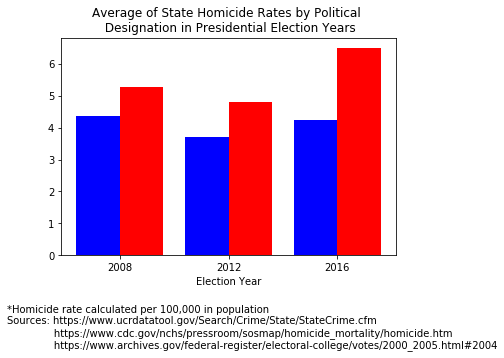

In [34]:
fig, ax1 = plt.subplots()

N=3
ind=np.arange(N)
width=.4

ax1.bar(ind, blue, width, color='blue', label="Blue")
ax1.bar(ind+width, red, width, color='red', label="Red")

ax1.set_xticks(ind + width / 2)
ax1.set_xticklabels(('2008', '2012', '2016'))
ax1.set_xlabel("Election Year")

plt.title("Average of State Homicide Rates by Political \n Designation in Presidential Election Years")

plt.figtext(0, -.2, '*Homicide rate calculated per 100,000 in population \n' \
            'Sources: https://www.ucrdatatool.gov/Search/Crime/State/StateCrime.cfm \n'\
            '               https://www.cdc.gov/nchs/pressroom/sosmap/homicide_mortality/homicide.htm \n' \
            '               https://www.archives.gov/federal-register/electoral-college/votes/2000_2005.html#2004', \
            horizontalalignment='left')

plt.savefig("Images/HRates_by_Des.png", bbox_inches='tight', pad_inches=1)

In [35]:
#Creating sample groups for a TTest
sample_blue_08 = poli_08_blue["HRate 08"]
sample_red_08 = poli_08_red["HRate 08"]

sample_blue_12 = poli_12_blue["HRate 12"]
sample_red_12 = poli_12_red["HRate 12"]

sample_blue_16 = poli_16_blue["HRate 16"]
sample_red_16 = poli_16_red["HRate 16"]

In [36]:
#Running ttests on samples
stats.ttest_ind(sample_blue_08, sample_red_08, equal_var=False)
P08=0.182469

stats.ttest_ind(sample_blue_12, sample_red_12, equal_var=False)
P12=0.05087216

stats.ttest_ind(sample_blue_16, sample_red_16, equal_var=False)
P16=0.01800191

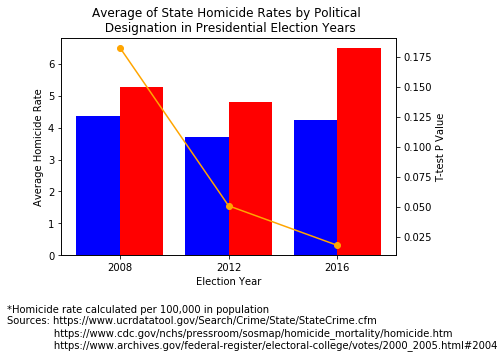

In [38]:
#plotting p values on top of previous plot
p_value=[P08, P12, P16]

fig, ax1 = plt.subplots()

N=3
ind=np.arange(N)
width=.4

ax1.bar(ind, blue, width, color='blue', label="Blue")
ax1.bar(ind+width, red, width, color='red', label="Red")
ax1.set_ylabel('Average Homicide Rate')
ax1.set_xticks(ind + width / 2)
ax1.set_xticklabels(('2008', '2012', '2016'))

ax2=ax1.twinx()
ax2.plot(ind+.2, p_value, color="orange", marker="o")
ax2.set_ylabel('T-test P Value')
ax1.set_xlabel('Election Year')


plt.title("Average of State Homicide Rates by Political \n Designation in Presidential Election Years")
plt.figtext(0, -.2, '*Homicide rate calculated per 100,000 in population \n' \
            'Sources: https://www.ucrdatatool.gov/Search/Crime/State/StateCrime.cfm \n'\
            '               https://www.cdc.gov/nchs/pressroom/sosmap/homicide_mortality/homicide.htm \n' \
            '               https://www.archives.gov/federal-register/electoral-college/votes/2000_2005.html#2004', \
            horizontalalignment='left')

plt.savefig("Images/HRates_by_Des_Pvalue.png", bbox_inches='tight', pad_inches=1)

## Homicide Rates by State Map for Each Election Year

In [39]:
#2008 election 
gmaps.configure(api_key=am_gkey)
blue_coords_08 = poli_08_blue[['latitude','longitude']].dropna()
red_coords_08= poli_08_red[['latitude','longitude']].dropna()

blue_weights=poli_08_blue["HRate 08"].astype(int)
red_weights=poli_08_red["HRate 08"].astype(int)

blue_marks_08=gmaps.symbol_layer(blue_coords_08, fill_color="blue", stroke_color="black", 
                                 stroke_opacity=0, scale=[i for i in blue_weights])

red_marks_08=gmaps.symbol_layer(red_coords_08, fill_color="red", stroke_color="black", 
                                 stroke_opacity=0, scale=[i for i in red_weights])

fig = gmaps.figure()
fig.add_layer(blue_marks_08)
fig.add_layer(red_marks_08)
fig

Figure(layout=FigureLayout(height='420px'))

In [40]:
#2012 election
blue_coords_12 = poli_12_blue[['latitude','longitude']]
red_coords_12= poli_12_red[['latitude','longitude']]

blue_weights_12=poli_12_blue["HRate 12"].astype(int)
red_weights_12=poli_12_red["HRate 12"].astype(int)

blue_marks_12=gmaps.symbol_layer(blue_coords_12, fill_color="blue", stroke_color="black", \
                                stroke_opacity=0, scale=[i for i in blue_weights_12])

red_marks_12=gmaps.symbol_layer(red_coords_12, fill_color="red", stroke_color="black", \
                                stroke_opacity=0, scale=[i for i in red_weights_12])

fig = gmaps.figure()
fig.add_layer(blue_marks_12)
fig.add_layer(red_marks_12)
fig


Figure(layout=FigureLayout(height='420px'))

In [41]:
#2016 election 
poli_16_blue.loc[poli_16_blue["HRate 16"]==0,"HRate 16"]=1
for_map_blue=poli_16_blue

poli_16_red.loc[poli_16_red["HRate 16"]==0, "HRate 16"]=1
for_map_red=poli_16_red

blue_coords_16 = for_map_blue[['latitude','longitude']]
red_coords_16= for_map_red[['latitude','longitude']]


blue_weights_16=for_map_blue["HRate 16"].astype(int)
red_weights_16=for_map_red["HRate 16"].astype(int)



blue_marks_16=gmaps.symbol_layer(blue_coords_16, fill_color="blue", stroke_color="black", \
                                stroke_opacity=0, scale=[i for i in blue_weights_16])

red_marks_16=gmaps.symbol_layer(red_coords_16, fill_color="red", stroke_color="black", \
                                stroke_opacity=0, scale=[i for i in red_weights_16])

fig = gmaps.figure()
fig.add_layer(blue_marks_16)
fig.add_layer(red_marks_16)
fig

Figure(layout=FigureLayout(height='420px'))

BEGIN ECONOMIC ANALYSIS

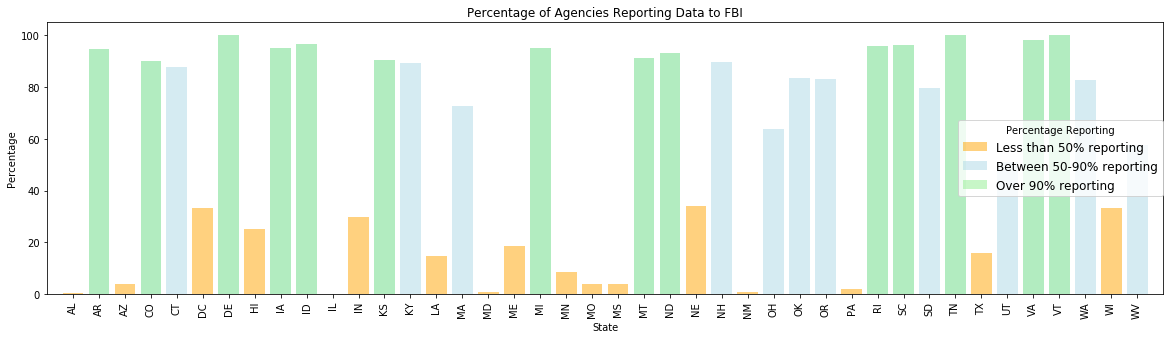

In [3]:
#PERCENTAGE OF AGENCIES REPORTING DATA TO THE FBI PER STATE
a_states = agency_df['state_abbr']
agency_pct = agency_df['Pct Active']
x_axis = np.arange(len(a_states))

plt.figure(figsize=(20, 5))

mask2 = agency_pct < 50
mask3 = agency_pct > 50
mask4 = agency_pct > 90


plt.bar(x_axis[mask2], agency_pct[mask2], color='orange', alpha=0.5, align='center', label="Less than 50% reporting")
plt.bar(x_axis[mask3], agency_pct[mask3], color='lightblue', alpha=0.5, align='center' ,label='Between 50-90% reporting')
plt.bar(x_axis[mask4], agency_pct[mask4], color='lightgreen', alpha=0.5, align='center' ,label='Over 90% reporting')


plt.legend(loc='right', borderaxespad=0, fontsize = 12, title= "Percentage Reporting") 

tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, a_states, rotation="vertical")

plt.xlim(-1, len(x_axis))

plt.title("Percentage of Agencies Reporting Data to FBI")
plt.xlabel("State")
plt.ylabel("Percentage")

plt.savefig("Images/Agencies_Reporting_to_FBI.png")

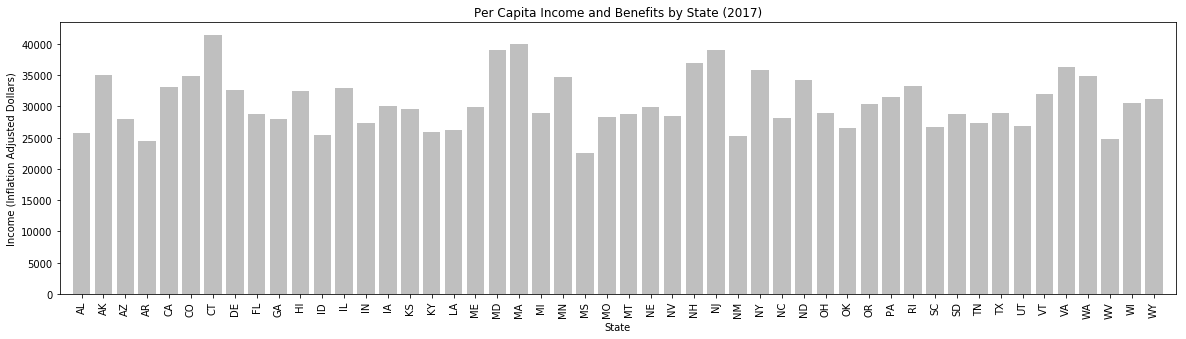

In [4]:
#PER CAPITA INCOME BY STATE FOR 2017 - - BASED ON 2017 CENSUS DATA ONLY 
c_states = ses_mrcensus['state_abbr']
per_capita = ses_mrcensus['Per_capita_income']
x_axis = np.arange(len(c_states))

plt.figure(figsize=(20, 5))
plt.bar(x_axis, per_capita, color='gray', alpha=0.5, align='center')

tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, c_states, rotation="vertical")

plt.xlim(-1, len(x_axis))

plt.title("Per Capita Income and Benefits by State (2017)")
plt.xlabel("State")
plt.ylabel("Income (Inflation Adjusted Dollars)")

plt.savefig("Images/State_PerCapita_Income_2017.png")

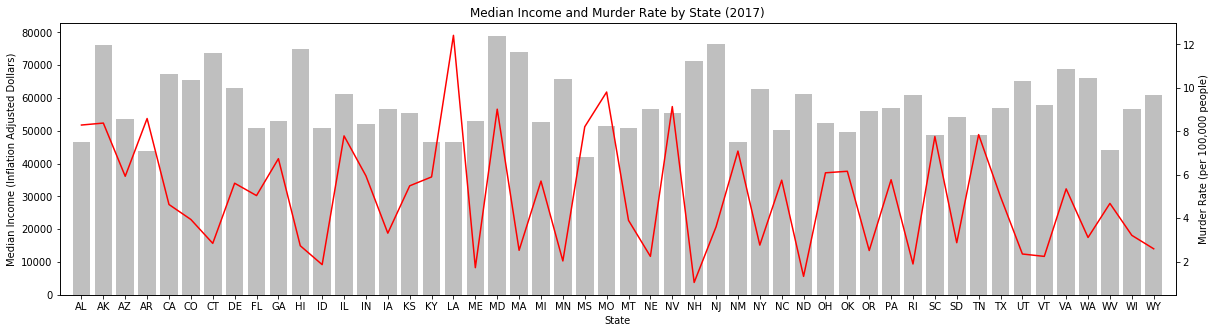

In [5]:
#MEDIAN EARNINGS BY STATE FOR 2017 with MURDER RATE BY STATE - - BASED ON 2017 CENSUS DATA ONLY 
c_states = ses_mrcensus['state_abbr']
median_income = ses_mrcensus['Total_median_income']
mrate = ses_mrcensus['Murder Rate']

x_axis = np.arange(len(c_states))

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

ax.bar(x_axis, median_income, color='gray', alpha=0.5, align='center')
ax2 = ses_mrcensus['Murder Rate'].plot(secondary_y=True, color='r')

tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, c_states, rotation="vertical")

plt.xlim(-1, len(x_axis))


plt.title("Median Income and Murder Rate by State (2017)")
ax.set_xlabel("State")
ax.set_ylabel("Median Income (Inflation Adjusted Dollars)")
ax2.set_ylabel("Murder Rate (per 100,000 people)")

plt.savefig("Images/Median_Income_and_Murder_Rate_2017.png")

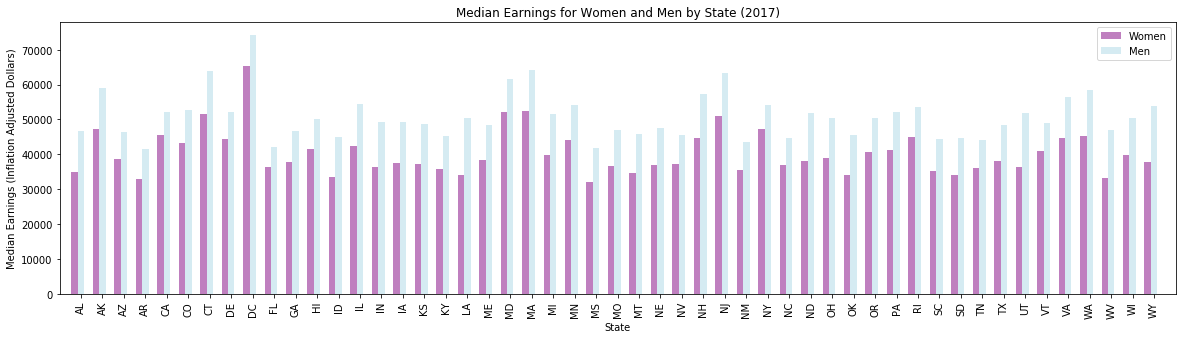

In [6]:
#MEDIAN EARNINGS (MALE & FEMALE SIDE-BY-SIDE) BY STATE FOR 2017 - - BASED ON 2017 CENSUS DATA ONLY 

c_states = ses_census_df['state_abbr']
med_earn_F = ses_census_df['Median_female']
med_earn_M = ses_census_df['Median_male']

x_axis = np.arange(len(c_states))

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

w = 0.3

women = ax.bar(x_axis-w, med_earn_F, color='purple', alpha=0.5, align='center', width = w)
men = ax.bar(x_axis, med_earn_M, color='lightblue', alpha=0.5, align='center', width = w)
#ax2 = ses_mrcensus['Murder Rate'].plot(secondary_y=True, color='y')


#ax2 = ses_state_v_sex_2017['Male Count'].plot(secondary_y=True, color='y')

tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, c_states, rotation="vertical")

plt.xlim(-1, len(x_axis))

plt.title("Median Earnings for Women and Men by State (2017)")
ax.set_xlabel("State")
ax.set_ylabel("Median Earnings (Inflation Adjusted Dollars)")
#ax2.set_ylabel("Murder Rate (per 100,000 people)")

#ax2.set_ylabel("Number of Male Homicide Victims by State")

plt.legend((women[0], men[0]), ('Women', 'Men'))

plt.savefig("Images/Male_and_Female_State_Median_Earnings_2017.png")


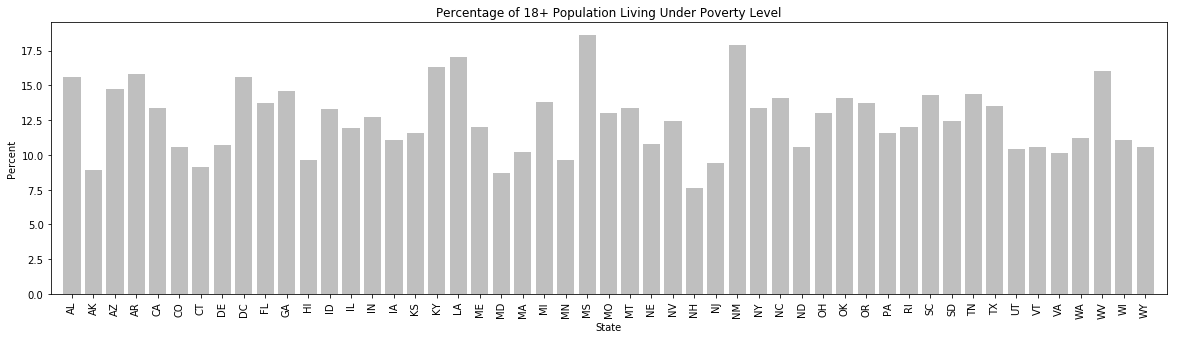

In [7]:
#PERCENTAGE OF 18+ POPULATION LIVING BELOW POVERTY LEVEL - BASED ON 2017 CENSUS DATA ONLY 
c_states = ses_census_df['state_abbr']
pop_pov = ses_census_df['Pct_Pov_pop_all18']
x_axis = np.arange(len(c_states))

plt.figure(figsize=(20, 5))
plt.bar(x_axis, pop_pov, color='gray', alpha=0.5, align='center')

tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, c_states, rotation="vertical")

plt.xlim(-1, len(x_axis))

plt.title("Percentage of 18+ Population Living Under Poverty Level")
plt.xlabel("State")
plt.ylabel("Percent")

plt.savefig("Images/Pct_Poverty_2017.png")

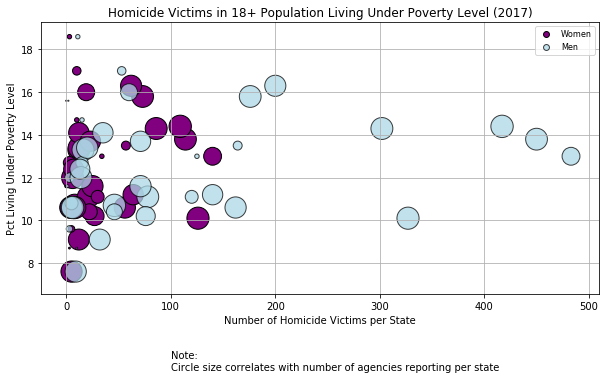

In [8]:
#NUMBER OF HOMICIDES IN POPULATION LIVING UNDER POVERTY LEVEL

#Put together the dataframe that includes census/poverty data, numbers of homicides by state, and agencies reporting
ses_state_v_sex_2017 = ses_state_v_sex_2017.rename(columns={'State': 'state_abbr'})

vcensus = pd.merge(ses_state_v_sex_2017, ses_census_df, on='state_abbr')
vcensus = pd.merge(agency_df, vcensus, on='state_abbr')

m_count = vcensus['Male Count']
f_count = vcensus['Female Count']
pct_pov = vcensus['Pct_Pov_pop_all18']
state_weight = vcensus['Pct Active']

plt.figure(figsize=(10, 5))

#Build the scatter plots for each city types
plt.scatter(f_count, pct_pov, marker="o", facecolors="purple", edgecolors="black", alpha=1,  s=state_weight*5, label='Women') 
plt.scatter(m_count, pct_pov, marker="o", facecolors="lightblue", edgecolors="black", alpha=0.75, s=state_weight*5, label='Men') 

#Incorporate the other graph properties
plt.grid()

plt.xlabel("Number of Homicide Victims per State")
plt.ylabel("Pct Living Under Poverty Level")
plt.title("Homicide Victims in 18+ Population Living Under Poverty Level (2017)")

#Create a legend
legend = plt.legend(fontsize = 8, loc="best") 
legend.legendHandles[0]._sizes = [35]
legend.legendHandles[1]._sizes = [35]


#Incorporate a text label regarding circle size
plt.text(100,3,"Note: \nCircle size correlates with number of agencies reporting per state", fontsize = 10)

#Save Figure
plt.savefig("Images/Scatter_Poverty_Homicide_2017.png", bbox_inches = 'tight')

plt.show()

In [9]:
#T-Test:  Median Income and Avg Murder Rate(2017) by State
#Question:  Is there a correlation between median income and the murder rate?
#Null Hypothesis:  no statistically significant difference between mean income and murder rate

m_count = vcensus['Male Count']
f_count = vcensus['Female Count']

def independent_ttest(data1, data2, alpha):
    # calculate means
    mean1, mean2 = mean(data1), mean(data2)
    # calculate standard errors
    se1, se2 = sem(data1), sem(data2)
    # standard error on the difference between the samples
    sed = sqrt(se1**2.0 + se2**2.0)
    # calculate the t statistic
    t_stat = (mean1 - mean2) / sed
    # degrees of freedom
    df = len(data1) + len(data2) - 2
    # calculate the critical value
    cv = t.ppf(1.0 - alpha, df)
    # calculate the p-value
    p = (1.0 - t.cdf(abs(t_stat), df)) * 2.0
    # return everything
    return t_stat, df, cv, p
 
# identify two independent samples
data1 = m_count
data2 = f_count

# calculate the t test
alpha = 0.05
t_stat, df, cv, p = independent_ttest(data1, data2, alpha)
print('t=%.3f, df=%d, cv=%.3f, p=%.3f' % (t_stat, df, cv, p))

# interpret via critical value
if abs(t_stat) <= cv:
    print('Accept null hypothesis that the means are equal.')
else:
    print('Reject the null hypothesis that the means are equal.')
    
# interpret via p-value
if p > alpha:
    print('Accept null hypothesis that the means are equal.')
else:
    print('Reject the null hypothesis that the means are equal.')


t=3.039, df=76, cv=1.665, p=0.003
Reject the null hypothesis that the means are equal.
Reject the null hypothesis that the means are equal.


In [ ]:
#MEDIAN EARNINGS BY STATE FOR 2017 with MURDER RATE BY STATE - - BASED ON 2017 CENSUS DATA ONLY 
m_count = vcensus['Male Count']
f_count = vcensus['Female Count']
mrate = ses_mrcensus['Murder Rate']

x_axis = np.arange(len(c_states))

fig = plt.figure(figsize=(20, 5))


plt.scatter(f_count, pct_pov, marker="o", facecolors="purple", edgecolors="black", alpha=1,  s=state_weight*5, label='Women') 
plt.scatter(m_count, pct_pov, marker="o", facecolors="lightblue", edgecolors="black", alpha=0.75, s=state_weight*5, label='Men') 

tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, c_states, rotation="vertical")

plt.xlim(-1, len(x_axis))


plt.title("Median Income and Murder Rate by State (2017)")
ax.set_xlabel("State")
ax.set_ylabel("Median Income (Inflation Adjusted Dollars)")
ax2.set_ylabel("Murder Rate (per 100,000 people)")

plt.savefig("Images/Median_Income_and_Murder_Rate_2017.png")